# CARBAJAL Guillaume

# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=http://www.datascience-paris-saclay.fr/en/site/newsView/12>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

# Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
* the date of departure
* the departure airport
* the arrival airport
* the mean and standard deviation of the number of weeks of the reservations made before the departure date
* a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. **The challenge in this RAMP is to find good data that can be correlated to flight traffic**.

### My approach of the challenge

I have to admit, my approach of the challenge wasn't very organized, for several reasons. This is the actual process I followed :
1. I worked with a few different machine learnings models on the raw data, in order to have an overview of the best score I could had without preprocessing the data. I used this information as a reference score.
2. I did the feature engineering, added the external data and implemented the new processed data with the model I already have. This step of the process was done back and forth for 2 reasons :
    - On the one hand, the results with the new added features depended on the machine learning models I used. Some new features were relevant according to some models, but I could noticed that the relevance differed among the models.
    - On the other hand, some ideas of external data that I had gave me new ideas of feature engineering, and vice versa. I also did feature engineering on the external data, in order to extract more information.
3. I analyzed the feature importance with machine learning models related to regression tree, such as Extra Trees or AdaBoost.

However, in order to display my results in a clear way, I decided to present this report as the following :
1. First of all, I will describe all the ideas of external data I had, and their respective relevances
2. Secondly, I will explain my reflections regarding feature engineering. In particular, I will present the "graph-of-airports" idea.
3. Finally, I will present the different regressors that I used, and especially the ones which worked the best.

### Evaluation of the RMSE

In order to compare the different machine learning models, I split the dataset into a train set and a test set. I trained and evaluate each marchine learning model on the train set by doing a cross-validation. Afterwards, in order to compare the best configuration of each model between each other, I evaluated their RMSE on the hold out test set.

Using the train set, I evaluated the RMSE using a stratified 5-Fold cross-validation scheme, in order to see the variance of RMSE on different splits of the train data set. The Stratified K-Fold cross-validation is relevant because the distribution of log_PAX is the same in each fold.

In the end, my best RMSE was of 0.3580 in cross-validation, and 0.3450 with the hold out test set.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
!pip install -U seaborn  # if you don't have it, or pip3 for python3

Exception:
Traceback (most recent call last):
  File "C:\Users\Guillaume\Anaconda2\lib\site-packages\pip\basecommand.py", line 211, in main
    status = self.run(options, args)
  File "C:\Users\Guillaume\Anaconda2\lib\site-packages\pip\commands\install.py", line 282, in run
    wheel_cache
  File "C:\Users\Guillaume\Anaconda2\lib\site-packages\pip\basecommand.py", line 272, in populate_requirement_set
    wheel_cache=wheel_cache
  File "C:\Users\Guillaume\Anaconda2\lib\site-packages\pip\req\req_install.py", line 213, in from_line
    wheel_cache=wheel_cache, constraint=constraint)
  File "C:\Users\Guillaume\Anaconda2\lib\site-packages\pip\req\req_install.py", line 67, in __init__
    req = pkg_resources.Requirement.parse(req)
  File "C:\Users\Guillaume\Anaconda2\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2985, in parse
    raise ValueError("No requirements found", s)
ValueError: ('No requirements found', '#')


In [3]:
# optional
import seaborn as sns; sns.set()

C:\Users\Guillaume\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Fetch the data and load it in pandas

In [3]:
data = pd.read_csv("data/public/public_train.csv")

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

In [24]:
data.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-10-21,DFW,SFO,14.600000,10.757779,11.575837
1,2012-09-13,LAX,ATL,14.730769,11.808097,13.364304
2,2012-09-04,ORD,IAH,8.470588,10.865349,5.885551
3,2012-08-13,DEN,PHX,8.200000,10.710562,6.292853
4,2012-09-10,ORD,SEA,12.090909,11.498355,9.138662


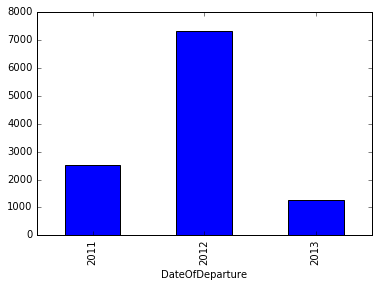

In [8]:
data['DateOfDeparture'].groupby(data['DateOfDeparture'].dt.year).count().plot(kind="bar")

# I. External Data

In [4]:
city_airport = pd.read_csv('external_data.csv')

In [182]:
city_airport.head()

,Unnamed: 0,IATA Code,AccentCity,Region,Population,Latitude,Longitude,ATL,LAX,ORD,MDW,DFW,JFK,LGA,DEN,SFO,CLT,LAS,PHX,IAH,MIA,SEA,EWR,MCO,MSP,DTW,BOS,PHL,FLL,BWI,SLC,HNL,SAN,TPA,PDX,2013,2011
0,0,ATL,Atlanta,GA,422908,33.748889,-84.388056,0.000000,3116.974264,943.737038,943.737038,1160.678408,1201.086020,1201.086020,1950.382267,3444.324017,364.513700,2809.388496,2562.101353,1129.006536,972.368257,3511.877282,1191.298249,644.957391,1460.723692,959.858635,1507.278255,1071.608363,939.269234,928.385258,2548.640193,7241.963480,3043.548921,669.124565,3496.863810,"45,308,407","44,414,121"
1,1,LAX,Los Angeles,CA,3877129,34.052222,-118.242778,3116.974264,0.000000,2807.375190,2807.375190,1995.709892,3944.300801,3944.300801,1337.747312,559.039735,3411.155527,368.276129,575.445418,2210.746565,3764.163980,1543.612345,3930.120477,3543.152568,2452.258377,3191.831918,4178.585393,3851.954502,3753.698521,3733.355225,932.507470,4125.063975,179.456398,3465.732728,1328.490020,"32,425,892","30,528,737"
2,2,ORD,Chicago,IL,2841952,41.850000,-87.650000,943.737038,2807.375190,0.000000,0.000000,1290.771853,1148.706025,1148.706025,1478.964650,2990.475437,944.143038,2450.912897,2337.798527,1509.878566,1910.174925,2795.831053,1134.452400,1582.274816,572.156149,384.601704,1371.210778,1071.937011,1875.477285,976.091432,2026.870731,6846.817083,2789.001359,1612.858675,2830.374986,"32,317,835","31,892,301"
3,3,MDW,Chicago,IL,2841952,41.850000,-87.650000,943.737038,2807.375190,0.000000,0.000000,1290.771853,1148.706025,1148.706025,1478.964650,2990.475437,944.143038,2450.912897,2337.798527,1509.878566,1910.174925,2795.831053,1134.452400,1582.274816,572.156149,384.601704,1371.210778,1071.937011,1875.477285,976.091432,2026.870731,6846.817083,2789.001359,1612.858675,2830.374986,"9,915,646","9,134,576"
4,4,DFW,Dallas,TX,1211704,32.783333,-96.800000,1160.678408,1995.709892,1290.771853,1290.771853,0.000000,2209.209951,2209.209951,1065.180366,2387.387539,1497.044378,1723.095658,1426.098462,361.738700,1788.021499,2705.385540,2196.387358,1549.273565,1387.954374,1608.661521,2496.753023,2091.428428,1773.685431,1951.950264,1608.439978,6108.174366,1904.784958,1477.589637,2628.090956,"29,038,128","27,518,358"


The above-mentioned dataframe shows all of the external data that I chose to keep in my final model. I basically focused on retrieving external information about each airport (e.g. total passenger boardings in a year, city, distance)

## I.a. Total passenger boardings of airport

My first idea was that the total number of passenger boardings of an airport in a year was one feature that could influence the prediction of the number of air passengers : for instance, an airport with a high number of departures and arrivals in a year would tend to have flights with high log_PAX, because it is a hub.

I retrieved the data of 2011, 2012 and 2013. However, I only kept the data of 2011 and 2013 because there was an outlier among the data of 2012.

In [6]:
affluence_2011=[]
for j in data['Departure'].unique():
    for i, item in enumerate(city_airport['IATA Code']):
        if j==item:
            affluence_2011.append((item, int(city_airport['2011'][i].replace(',',''))))
affluence_2011 = dict(affluence_2011)

In [7]:
affluence_2013=[]
for j in data['Departure'].unique():
    for i, item in enumerate(city_airport['IATA Code']):
        if j==item:
            affluence_2013.append((item, int(city_airport['2013'][i].replace(',',''))))
affluence_2013 = dict(affluence_2013)

In [178]:
city_airport[['IATA Code','2013', '2011']].head()

,IATA Code,2013,2011
0,ATL,"45,308,407","44,414,121"
1,LAX,"32,425,892","30,528,737"
2,ORD,"32,317,835","31,892,301"
3,DFW,"29,038,128","27,518,358"
4,JFK,"25,036,358","23,664,830"


For each flight, I added the total number of passenger boardings of both the departure and arrival aiports, in order to characterize better each particular aerial line (ex : all aerial lines BOS - SFO within March 2012).

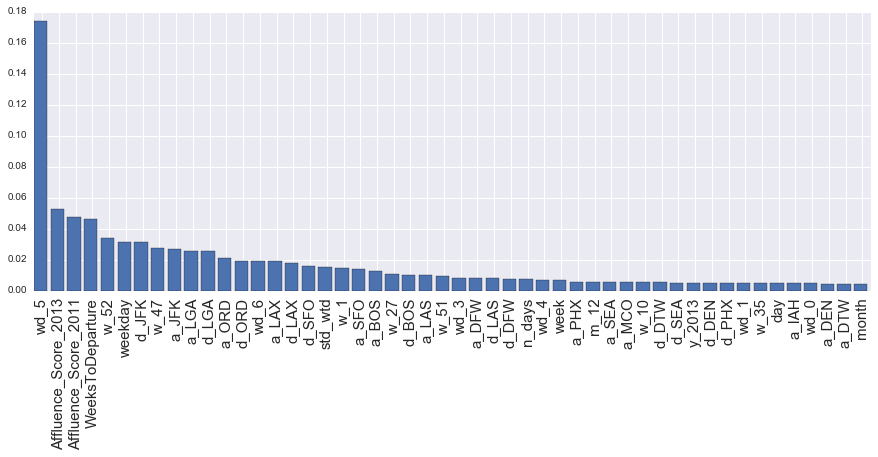

In [9]:
from IPython.display import Image
Image("affluence score.png")

As above mentioned in the chart, it was one of most important features of the Random Forest.

## I.b. City name and City population

I noticed that some airports were in the same city (for instance, New-York), so I decided to create dummy variables to characterize this statement

In [5]:
city_airport[['IATA Code','AccentCity']].head()

,IATA Code,AccentCity
0,ATL,Atlanta
1,LAX,Los Angeles
2,ORD,Chicago
3,MDW,Chicago
4,DFW,Dallas


In [8]:
city_dep=[]
for j in data['Departure']:
    for i, item in enumerate(city_airport['IATA Code']):
        if j==item:
            city_dep.append(city_airport['AccentCity'][i])

In [9]:
city_arr=[]
for j in data['Arrival']:
    for i, item in enumerate(city_airport['IATA Code']):
        if j==item:
            city_arr.append(city_airport['AccentCity'][i])

This information proved to be relevant, especially when it was combined with other features, such as the total number of flight departures and arrivals in a city.

I also tried to include the population of each city as a feature. The hypothesis was that a city with a large number of inhabitants could lead to more passengers for an aerial line.

In [6]:
city_airport[['IATA Code','AccentCity','Population',]].head()

,IATA Code,AccentCity,Population
0,ATL,Atlanta,422908
1,LAX,Los Angeles,3877129
2,ORD,Chicago,2841952
3,MDW,Chicago,2841952
4,DFW,Dallas,1211704


In [22]:
city_pop_dep=[]
for j in data['Departure']:
    for i, item in enumerate(city_airport['IATA Code']):
        if j==item:
            city_pop_dep.append(city_airport['Population'][i])
city_pop_arr=[]
for j in data['Arrival']:
    for i, item in enumerate(city_airport['IATA Code']):
        if j==item:
            city_pop_arr.append(city_airport['Population'][i])

However it led to poor results of RMSE. Therefore I decided not to take this feature into account.

## I.c. Distance between airports

Another feature that I thought could be important was the distance between airports. The idea was that for a long distance flight, there were more passengers because they linked 2 majors cities of the US. Therefore, with the geolocation of the airports and the package Geopy, I computed the distance matrix between airports. 

In [31]:
city_airport[city_airport.columns[8:16]].head()

,ATL,LAX,ORD,MDW,DFW,JFK,LGA,DEN
0,0.000000,3116.974264,943.737038,943.737038,1160.678408,1201.086020,1201.086020,1950.382267
1,3116.974264,0.000000,2807.375190,2807.375190,1995.709892,3944.300801,3944.300801,1337.747312
2,943.737038,2807.375190,0.000000,0.000000,1290.771853,1148.706025,1148.706025,1478.964650
3,943.737038,2807.375190,0.000000,0.000000,1290.771853,1148.706025,1148.706025,1478.964650
4,1160.678408,1995.709892,1290.771853,1290.771853,0.000000,2209.209951,2209.209951,1065.180366


In [10]:
distance=[]
for i, j in zip(data['Departure'], data['Arrival']):
    k = city_airport[city_airport['IATA Code'] == i].index.tolist()[0]
    distance.append(city_airport[j][k])

It led to a substantial decrease of the RMSE : it diminished by 0.01 on average for each regressor that I used.

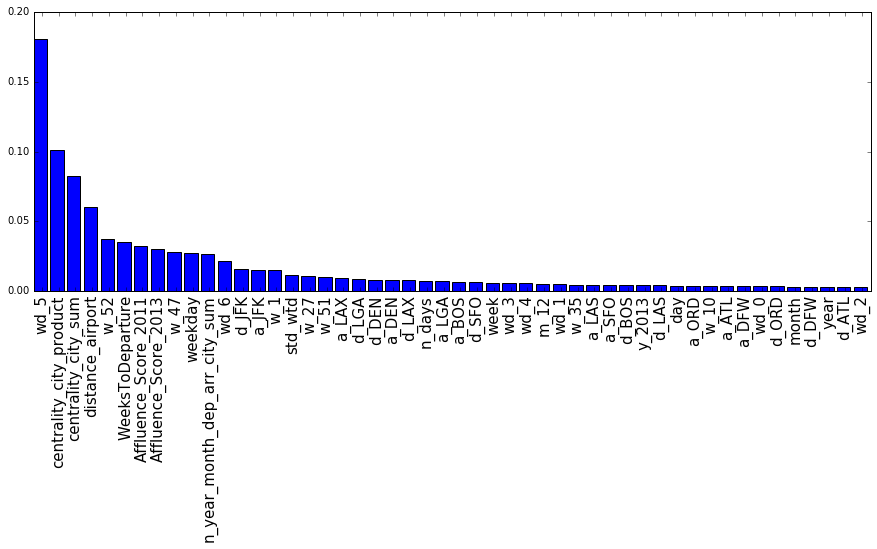

In [32]:
Image("distance airport.png")

As mentioned above for the feature importances with a Random Forest regressor, the distance between airports was one of the best features.

## I.d. Oil Prices

Finally, I also thought that oil prices could have an influence on the number of passengers, because higher oil prices could lead to more expensive airplane tickets, and thereby fewer people in the plane.

I created 2 features : one with weekly average price of oil for a given year, and one with the weekly average price of oil of the previous year.

However, it led to poor results, so I decided not to keep them in my model.

In [98]:
oil_prices = pd.read_csv('Oil_prices_year.csv')

In [100]:
oil_prices = dict(zip(oil_prices['year_week'], oil_prices['VALUE']))

In [101]:
df = data.copy()
df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
df['week'] = df['DateOfDeparture'].dt.week.astype(str)
df['year'] = df['DateOfDeparture'].dt.year.astype(str)
df['year_week'] = df[df.columns[[7,6]]].apply(lambda x: '-'.join(x),axis=1)
df['oil_prices'] = df['year_week'].map(oil_prices)

In [31]:
def set_oil_prices(data):
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['week'] = df['DateOfDeparture'].dt.week.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['year_week'] = df[df.columns[[6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['oil_prices'] = df['year_week'].map(oil_prices)

# II. Preprocessing for prediction

# What I did

In order to categorize each flight (departure, arrival), I thought it would be relevant to look for the properties of each airport, and then mix the properties of the airport of departure with the properties of the airport of arrival.

For example, for a given flight, I took :
- the total number of departure in the airport of departure in a month
- the total number of arrival in the airport of arrival in a month

Finally, I did a 3rd feature by doing a sum with these 2 features

## II.a. Count the number of departure / arrival by airport

Regarding external data, the idea of total number of passenger boardings gave me the idea to visualize the date of flight for a given aerial line within a year. For example, I observed the following distributionn for the aerial line LAX - ATL :

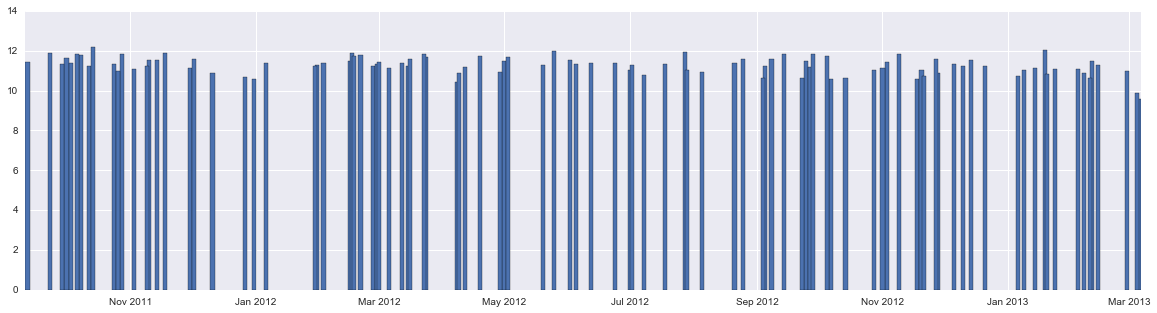

In [63]:
plot_ndays('LAX','ATL')

One can observe that some flight dates are very close, and that the sparsity is high for other dates.

As a result, I had the idea of counting the number of flights for a given aerial for each week. However it led to poor results. Nevertheless, when I tried this idea for each month, it provided an important feature.

Therefore, for each departure airport, I counted the total number of departures from that airport, within a month.

In [11]:
def current_month_dep(data):
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.month.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['year_month_dep'] = df[['Departure','month','year']].apply(lambda x: '-'.join(x),axis=1)
    n_month_year_dep = dict(df['Departure'].groupby(df['year_month_dep']).count())
    df['n_year_month_dep'] = df['year_month_dep'].map(n_month_year_dep)
    del df['year_month_dep']
    return df

In [12]:
df_6 = current_month_dep(data)

In [7]:
df_6.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,month,year,n_year_month_dep
0,2012-10-21,DFW,SFO,14.600000,10.757779,11.575837,10,2012,49
1,2012-09-13,LAX,ATL,14.730769,11.808097,13.364304,9,2012,58
2,2012-09-04,ORD,IAH,8.470588,10.865349,5.885551,9,2012,72
3,2012-08-13,DEN,PHX,8.200000,10.710562,6.292853,8,2012,43
4,2012-09-10,ORD,SEA,12.090909,11.498355,9.138662,9,2012,72


I also did the same for each arrival airport.

In [13]:
def current_month_arr(data):
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.month.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['year_month_arr'] = df[df.columns[[2,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    n_month_year_arr = dict(df['Arrival'].groupby(df['year_month_arr']).count())
    df['n_year_month_arr'] = df['year_month_arr'].map(n_month_year_arr)
    del df['year_month_arr']
    return df

In [14]:
df_7 = current_month_arr(data)

In [10]:
df_7.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,month,year,n_year_month_arr
0,2012-10-21,DFW,SFO,14.600000,10.757779,11.575837,10,2012,47
1,2012-09-13,LAX,ATL,14.730769,11.808097,13.364304,9,2012,68
2,2012-09-04,ORD,IAH,8.470588,10.865349,5.885551,9,2012,8
3,2012-08-13,DEN,PHX,8.200000,10.710562,6.292853,8,2012,12
4,2012-09-10,ORD,SEA,12.090909,11.498355,9.138662,9,2012,25


These features proved to be revelant, as they diminished the RMSE, especially when these features were summed up into a 3rd feature. In that case the new feature was better characterizing a given aerial line.  

## II.b. Count the Number of flights in cities

As I stated in the Section I.b., I also computed the number of departures and arrivals in a given city. It improved slightly the results.

In [15]:
def current_month_city_dep(data):
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.month.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['city_dep'] = city_dep
    
    df['year_month_dep'] = df[df.columns[[8,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    n_month_year_dep = dict(df['city_dep'].groupby(df['year_month_dep']).count())
    df['n_year_month_city_dep'] = df['year_month_dep'].map(n_month_year_dep)
    del df['year_month_dep']
    return df

In [29]:
df_11 = current_month_city_dep(data)

In [32]:
def current_month_city_arr(data):
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.month.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['city_arr'] = city_arr
    
    df['year_month_arr'] = df[df.columns[[8,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    n_month_year_dep = dict(df['city_arr'].groupby(df['year_month_arr']).count())
    df['n_year_month_city_arr'] = df['year_month_arr'].map(n_month_year_dep)
    del df['year_month_arr']
    return df


In [33]:
df_12 = current_month_city_arr(data)

## II.c. Graph of airports

By creating the above-mentioned features related to the number of departures and arrivals for a given airport, I thought I could improve the model. Indeed, all the flights between airports could be seen as interactions. As a result, I decided to explore this idea by creating of graph : each airport could be seen as node, and each flight (departure-arrival) as an edge. Therefore, for each month, I made a list of all the flights between airports in order to create a graph.

Then I computed several properties of the nodes of each graph : the degree of centraliy, the betweeness centrality, the load centrality. In addition, I computed the connecitivity between 2 nodes.

In [17]:
import networkx as nx
def centrality_month_airports(data):    
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.week.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['year_month'] = df[df.columns[[6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['year_month_dep'] = df[df.columns[[1,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['year_month_arr'] = df[df.columns[[2,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    year_month = pd.unique(df['year_month'])
    G = nx.Graph()
    centrality = {}

    for i, item in enumerate(year_month):
        sub_df = df[df['year_month'] == item][['Departure','Arrival']]
        list_dep_arr = zip(sub_df['Departure'], sub_df['Arrival'])
        G.add_edges_from(list_dep_arr)
        #G.number_of_nodes()
        #G.number_of_edges()
        centrality_month = nx.degree_centrality(G)
        centrality_month = pd.DataFrame(centrality_month.items())
        centrality_month['year_month'] = [item] * centrality_month.shape[0]
        centrality_month['airport_year_month'] = centrality_month[centrality_month.columns[[0,2]]].apply(lambda x: '-'.join(x),axis=1)
        centrality_month =dict(zip(centrality_month['airport_year_month'], centrality_month[1]))

        z = centrality.copy()
        z.update(centrality_month)
        centrality = z
    df['centrality_month_dep'] = df['year_month_dep'].map(centrality)
    df['centrality_month_arr'] = df['year_month_arr'].map(centrality)
    return df

In [18]:
def centrality_month_cities(data):    
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.week.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['year_month'] = df[df.columns[[6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['city_dep'] = city_dep
    df['city_arr'] = city_arr
    
    df['year_month_dep'] = df[df.columns[[9,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['year_month_arr'] = df[df.columns[[10,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    year_month = pd.unique(df['year_month'])
    G = nx.Graph()
    centrality = {}

    for i, item in enumerate(year_month):
        sub_df = df[df['year_month'] == item][['city_dep','city_arr']]
        list_dep_arr = zip(sub_df['city_dep'], sub_df['city_arr'])
        G.add_edges_from(list_dep_arr)
        #G.number_of_nodes()
        #G.number_of_edges()
        centrality_month = nx.degree_centrality(G)
        centrality_month = pd.DataFrame(centrality_month.items())
        centrality_month['year_month'] = [item] * centrality_month.shape[0]
        centrality_month['city_year_month'] = centrality_month[centrality_month.columns[[0,2]]].apply(lambda x: '-'.join(x),axis=1)
        centrality_month =dict(zip(centrality_month['city_year_month'], centrality_month[1]))

        z = centrality.copy()
        z.update(centrality_month)
        centrality = z
    df['centrality_city_dep'] = df['year_month_dep'].map(centrality)
    df['centrality_city_arr'] = df['year_month_arr'].map(centrality)
    return df
    

In [19]:
df_9 = centrality_month_airports(data)

In [20]:
df_10 = centrality_month_cities(data)

In [21]:
def btw_centrality_month_airports(data):    
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.week.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['year_month'] = df[df.columns[[6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['year_month_dep'] = df[df.columns[[1,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['year_month_arr'] = df[df.columns[[2,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    year_month = pd.unique(df['year_month'])
    G = nx.Graph()
    btw_centrality = {}

    for i, item in enumerate(year_month):
        sub_df = df[df['year_month'] == item][['Departure','Arrival']]
        list_dep_arr = zip(sub_df['Departure'], sub_df['Arrival'])
        G.add_edges_from(list_dep_arr)
        #G.number_of_nodes()
        #G.number_of_edges()
        centrality_month = nx.betweenness_centrality(G)
        centrality_month = pd.DataFrame(centrality_month.items())
        centrality_month['year_month'] = [item] * centrality_month.shape[0]
        centrality_month['airport_year_month'] = centrality_month[centrality_month.columns[[0,2]]].apply(lambda x: '-'.join(x),axis=1)
        centrality_month =dict(zip(centrality_month['airport_year_month'], centrality_month[1]))

        z = btw_centrality.copy()
        z.update(centrality_month)
        btw_centrality = z
    df['btw_centrality_month_dep'] = df['year_month_dep'].map(btw_centrality)
    df['btw_centrality_month_arr'] = df['year_month_arr'].map(btw_centrality)
    return df

In [22]:
df_13 = btw_centrality_month_airports(data)

In [23]:
def load_centrality_month_airports(data):    
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.week.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['year_month'] = df[df.columns[[6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['year_month_dep'] = df[df.columns[[1,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    df['year_month_arr'] = df[df.columns[[2,6,7]]].apply(lambda x: '-'.join(x),axis=1)
    year_month = pd.unique(df['year_month'])
    G = nx.Graph()
    load_centrality = {}

    for i, item in enumerate(year_month):
        sub_df = df[df['year_month'] == item][['Departure','Arrival']]
        list_dep_arr = zip(sub_df['Departure'], sub_df['Arrival'])
        G.add_edges_from(list_dep_arr)
        #G.number_of_nodes()
        #G.number_of_edges()
        centrality_month = nx.load_centrality(G)
        centrality_month = pd.DataFrame(centrality_month.items())
        centrality_month['year_month'] = [item] * centrality_month.shape[0]
        centrality_month['airport_year_month'] = centrality_month[centrality_month.columns[[0,2]]].apply(lambda x: '-'.join(x),axis=1)
        centrality_month =dict(zip(centrality_month['airport_year_month'], centrality_month[1]))

        z = load_centrality.copy()
        z.update(centrality_month)
        load_centrality = z
    df['load_centrality_month_dep'] = df['year_month_dep'].map(load_centrality)
    df['load_centrality_month_arr'] = df['year_month_arr'].map(load_centrality)
    return df

In [24]:
df_14 = load_centrality_month_airports(data)

In [25]:
def set_connectivity(data):    
    df = data.copy()
    df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
    df['month'] = df['DateOfDeparture'].dt.week.astype(str)
    df['year'] = df['DateOfDeparture'].dt.year.astype(str)
    df['arr_dep'] = df[df.columns[[1,2]]].apply(lambda x: '-'.join(x),axis=1)

    G = nx.Graph()
    connectivity = {}

    list_dep_arr = zip(df['Departure'], df['Arrival'])
    G.add_edges_from(list_dep_arr)
    #G.number_of_nodes()
    #G.number_of_edges()
    connectivity = nx.all_pairs_node_connectivity(G)
    for j, jtem in enumerate(connectivity):
        if j==0:
            a=[jtem]*len(connectivity[jtem])
            d = pd.DataFrame(connectivity[jtem].items())
            d = pd.concat([pd.DataFrame(a),d], axis=1)
            c = d.copy()
        a=[jtem]*len(connectivity[jtem])
        d = pd.DataFrame(connectivity[jtem].items())
        d = pd.concat([pd.DataFrame(a),d], axis=1)
        c = c.append(d)
    c['arr_dep'] = c[c.columns[[0]]].apply(lambda x: '-'.join(x),axis=1)
    connectivity_dep_arr = dict(zip(c['arr_dep'],c[1]))

    df['connectivity'] = df['arr_dep'].map(connectivity_dep_arr)
    return df


In [26]:
df_15 = set_connectivity(data)

In [146]:
df = data.copy()
df['DateOfDeparture'] = pd.to_datetime(df['DateOfDeparture'])
df['month'] = df['DateOfDeparture'].dt.week.astype(str)
df['year'] = df['DateOfDeparture'].dt.year.astype(str)
df['arr_dep'] = df[df.columns[[1,2]]].apply(lambda x: '-'.join(x),axis=1)

G = nx.Graph()
connectivity = {}

list_dep_arr = zip(df['Departure'], df['Arrival'])
G.add_edges_from(list_dep_arr)
#G.number_of_nodes()
#G.number_of_edges()
connectivity = nx.shortest_path_length(G)

These features proved to be relevant, because they slightly decreased the RMSE.

## II.d. Conclusion of the preprocessing

In [34]:
data_encoded = data.copy()

In [35]:
data_encoded['Affluence_Dep_2011'] = data['Departure'].map(affluence_2011)
data_encoded['Affluence_Arr_2011'] = data['Arrival'].map(affluence_2011)
data_encoded['Affluence_Score_2011'] = data_encoded['Affluence_Arr_2011'] + data_encoded['Affluence_Dep_2011']

data_encoded['Affluence_Dep_2013'] = data['Departure'].map(affluence_2013)
data_encoded['Affluence_Arr_2013'] = data['Arrival'].map(affluence_2013)
data_encoded['Affluence_Score_2013'] = data_encoded['Affluence_Arr_2013'] + data_encoded['Affluence_Dep_2013']

data_encoded = data_encoded.drop('Affluence_Dep_2011', axis=1)
data_encoded = data_encoded.drop('Affluence_Arr_2011', axis=1)

data_encoded = data_encoded.drop('Affluence_Dep_2013', axis=1)
data_encoded = data_encoded.drop('Affluence_Arr_2013', axis=1)


data_encoded['DateOfDeparture'] = pd.to_datetime(data_encoded['DateOfDeparture'])
data_encoded['year'] = data_encoded['DateOfDeparture'].dt.year
data_encoded['month'] = data_encoded['DateOfDeparture'].dt.month
data_encoded['day'] = data_encoded['DateOfDeparture'].dt.day
data_encoded['weekday'] = data_encoded['DateOfDeparture'].dt.weekday
data_encoded['week'] = data_encoded['DateOfDeparture'].dt.week
data_encoded['n_days'] = data_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['year'], prefix='y'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['month'], prefix='m'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['day'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['weekday'], prefix='wd'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['week'], prefix='w'))


data_encoded['distance_airport'] = distance

data_encoded = data_encoded.join(df_11['n_year_month_city_dep'])
data_encoded = data_encoded.join(df_12['n_year_month_city_arr'])

data_encoded['n_year_month_dep_arr_city_sum'] = data_encoded['n_year_month_city_dep'] + data_encoded['n_year_month_city_arr']
data_encoded = data_encoded.drop('n_year_month_city_dep', axis=1)
data_encoded = data_encoded.drop('n_year_month_city_arr', axis=1)


data_encoded = pd.concat([data_encoded, df_9[['centrality_month_dep','centrality_month_arr']]], axis = 1)
data_encoded['centrality_sum'] = data_encoded['centrality_month_arr'] + data_encoded['centrality_month_dep']
data_encoded['centrality_product'] = data_encoded['centrality_month_arr']*data_encoded['centrality_month_dep']


data_encoded = pd.concat([data_encoded, df_10[['centrality_city_dep','centrality_city_arr']]], axis = 1)
data_encoded['centrality_city_sum'] = data_encoded['centrality_city_arr'] + data_encoded['centrality_city_dep']
data_encoded['centrality_city_product'] = data_encoded['centrality_city_arr']*data_encoded['centrality_city_dep']

data_encoded = data_encoded.drop('centrality_city_dep', axis = 1)
data_encoded = data_encoded.drop('centrality_city_arr', axis = 1)


data_encoded = pd.concat([data_encoded, df_13[['btw_centrality_month_dep','btw_centrality_month_arr']]], axis = 1)
data_encoded['btw_centrality_diff'] = data_encoded['btw_centrality_month_arr'] - data_encoded['btw_centrality_month_dep']

                          
data_encoded = pd.concat([data_encoded, df_14[['load_centrality_month_arr','load_centrality_month_dep']]], axis = 1)
data_encoded['load_centrality_sum'] = data_encoded['load_centrality_month_arr'] + data_encoded['load_centrality_month_dep']
data_encoded['load_centrality_product'] = data_encoded['load_centrality_month_arr']*data_encoded['load_centrality_month_dep']


data_encoded = pd.concat([data_encoded, df_15['connectivity']], axis = 1)

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Departure'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Arrival'], prefix='a'))
data_encoded = data_encoded.drop('Departure', axis=1)
data_encoded = data_encoded.drop('Arrival', axis=1)

In [105]:
data_encoded.shape

(11128, 162)

# III. Regressors

I tried a few different regressors : LinearRegression, RandomForest, ExtraTrees, AdaBoost and finally GradientBoosting. Eventually, I had the best results with GradientBoosting so I decide to keep it.

I chose to treat the data with models related to regressions trees, because they need fewer data processing than the other models. One of the greatest advantages is that there are ensemble models, so their predictions are often more accurate since they combine the results of several predictors. In addition, it is possible to observe the feature importance. P

In [36]:
features = data_encoded.drop(['log_PAX','DateOfDeparture'], axis=1)
X_columns = data_encoded.columns.drop(['log_PAX','DateOfDeparture'])
X = features.values
y = data_encoded['log_PAX'].values

In [37]:
### return index of d_airport
features.columns.values

array(['WeeksToDeparture', 'std_wtd', 'Affluence_Score_2011',
       'Affluence_Score_2013', 'year', 'month', 'day', 'weekday', 'week',
       'n_days', 'y_2011', 'y_2012', 'y_2013', 'm_1', 'm_2', 'm_3', 'm_4',
       'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'd_1',
       'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18',
       'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26',
       'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'wd_0', 'wd_1', 'wd_2',
       'wd_3', 'wd_4', 'wd_5', 'wd_6', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5',
       'w_6', 'w_7', 'w_8', 'w_9', 'w_10', 'w_11', 'w_12', 'w_13', 'w_14',
       'w_15', 'w_16', 'w_17', 'w_18', 'w_19', 'w_20', 'w_21', 'w_22',
       'w_23', 'w_24', 'w_25', 'w_26', 'w_27', 'w_28', 'w_29', 'w_30',
       'w_31', 'w_32', 'w_33', 'w_34', 'w_35', 'w_36', 'w_37', 'w_38',
       'w_39', 'w_40', 'w_41', 'w_42', 'w_43', 'w_44', 'w_45', 'w_46',

In [38]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

In [39]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(y_train, n_folds=5, shuffle = True, random_state=41)

C:\Users\Guillaume\Anaconda2\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


## III.a. LinearRegression

First of all, I implemented a Linear Regression model in order to have an overview of the different coefficients I could have with. 

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

reg = LinearRegression()

scores = cross_val_score(reg, X_train, y_train, cv=skf, scoring='mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.5827 +/-0.0194


When I visualized the coefficients, I noticed that the LinearRegression model couldn't capture all the information. For example, I plotted the coefficients related to the years :

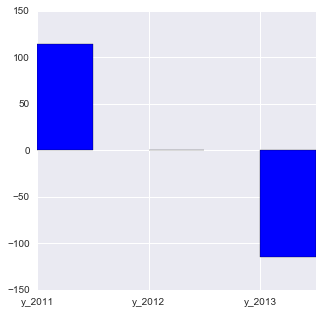

In [11]:
Image("year.png")

One can see that 2011 and 2013 seem to have a great influence on log_PAX. However, this is due to the sample distribution : there are more data in 2012 than for the other years.

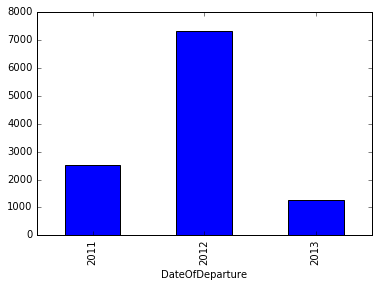

In [10]:
Image("Date of departure year.png")

## III.b. Random Forests

In [34]:
%%time
from sklearn.ensemble import RandomForestRegressor

Wall time: 203 ms


## III.c. ExtraTrees

In [161]:
from sklearn.ensemble import ExtraTreesRegressor

In [162]:
%%time
n_estimators = 600
max_features = 90
min_samples_split = 10
bootstrap = True

reg = ExtraTreesRegressor(n_estimators=n_estimators,
                            max_features=max_features,
                            min_samples_split = min_samples_split,
                            n_jobs=3,
                            random_state=10)

scores = cross_val_score(reg, X_train, y_train, cv=skf, scoring='mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.3950 +/-0.0239
Wall time: 2min 4s


## III.d. Gradient Boosting

I got the best results with this configuration of GradientBoosting.

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

In [45]:
loss='ls'
learning_rate=0.2
n_estimators=2000
subsample=1.0
min_samples_leaf=1
min_weight_fraction_leaf=0.0
#max_depth=8
min_samples_split= 10
random_state=None
max_features=100
max_leaf_nodes=None
warm_start=False
presort='auto'

reg = GradientBoostingRegressor(loss= loss,
                                learning_rate= learning_rate,
                                n_estimators= n_estimators,
                                subsample=1.0,
                                #max_depth = max_depth,
                                min_samples_split= min_samples_split,
                                max_features = max_features,
                                random_state=10,
                                alpha=0.5)

scores = cross_val_score(reg, X_train, y_train, cv=skf, scoring='mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.3604 +/-0.0179


In [44]:
import xgboost as xgb

ImportError: No module named xgboost

In [ ]:
reg = xgb.XGBRegressor(n_estimators=2000,max_depth=8)

scores = cross_val_score(reg, X_train, y_train, cv=skf, scoring='mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

# CONCLUSION

I did a great improvement regarding my RMSE during the data camp : I started with RMSE = 0.64 with the LinearRegression model, and finally finished with RMSE = 0.3580 (cross-validation) with the GradientBoosting model.

I noticed that the importance of the features are very dependent on the machine learning model we use. Therefore, I spent most of time thinking about feature engineering, more than combining regressors between them.

What I could have done if I had more time :
1. Data Visualization : I didn't use it completely. It could have given more ideas about feature engineering. Plus, I should have visualized the graphs that I did !
2. Feature Selection : given the small number of features, I didn't use any package of feature selection. I should have tried SelecKBest with f-regression as a criterion, in order to see what was the best subgroup of features.
3. Machine Learning model : I wanted to try a Neural Network since I read some papers related to air passengers in which NN were used. Unfortunately, I had no time.
4. Clustering : I didn't do it. I think it may have helped me to identify the different types of flights (e.g. flights related to work, to holidays, etc.)